# Installing libraries and downloading data

In [2]:
! pip install music21
! pip install mido
! pip install pitchscapes -U
! pip install pykeops

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 327kB 8.5MB/s 
  Created wheel for pykeops: filename=pykeops-1.4.1-cp36-none-any.whl size=434125 sha256=6f5cfbb1cc166cc98d02ad8608200c6029cb9bb871f65f3f6378faa6abe8e5b5
  Stored in directory: /root/.cache/pip/wheels/84/a0/62/52df258b8d6a36e878eaed84e43e1f06c13eb73ceb966ff232
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=c81784cb951f786a7c381812bb5076a4885836e5e95370a7072bd62bb00cf92d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built pykeops GPUtil


In [1]:
! wget -O slice_data.pt https://www.dropbox.com/s/wv3tsrlidamp7zm/alex_data.pt?dl=0
! unzip scores.zip

--2020-11-14 14:12:05--  https://www.dropbox.com/s/wv3tsrlidamp7zm/alex_data.pt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wv3tsrlidamp7zm/alex_data.pt [following]
--2020-11-14 14:12:06--  https://www.dropbox.com/s/raw/wv3tsrlidamp7zm/alex_data.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6398accf32565ea8c2cfd85163.dl.dropboxusercontent.com/cd/0/inline/BDIjm6WvLEtFmv-FV1TXlPVFG3t8QvpuD-rZKJJRQ8e4QU60h4OAzqUf3RABY-bDW-8QGzJwh2SOkOmqbrEKX3OGwjErw2WG_aAzSYXmwJ4dDKxoTHPJ5xIakHo-4sc9mlg/file# [following]
--2020-11-14 14:12:06--  https://uc6398accf32565ea8c2cfd85163.dl.dropboxusercontent.com/cd/0/inline/BDIjm6WvLEtFmv-FV1TXlPVFG3t8QvpuD-rZKJJRQ8e4QU60h4OAzqUf3RABY-bDW-8QGzJwh2SOkOmqbrEKX3OGwjErw2WG_aAzSYXmwJ4dD


Fitting a Gaussian Mixture Model
=====================================

In this tutorial, we show how to use KeOps to fit
a Gaussian Mixture Model with a **custom sparsity prior**
through **gradient descent** on the empiric log-likelihood.


Setup
-----------

Standard imports:



In [3]:
import matplotlib.cm as cm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.nn import Module, Parameter
from torch.nn.functional import softmax, log_softmax
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pitchscapes.reader as rd
import pitchscapes.plotting as pt
import os
from pykeops.torch import Kernel, kernel_product
from sklearn.manifold import Isomap
import plotly.express as px
from IPython.display import HTML
import pandas as pd
import random
%matplotlib inline

In [4]:
class DirichletMixture(Module):
    def __init__(self, M, sparsity=0, D=2):
        super(DirichletMixture, self).__init__()

        self.alphas = Parameter(torch.rand(M, D).type(dtype))

        self.w = Parameter(torch.ones(M, 1).type(dtype))
        self.sparsity = sparsity

    def param(self):
        return self.alphas**2
    
    def update_norm_log(self):
        (M, D) = self.alphas.shape
        norm = - torch.lgamma(self.param()).sum(1) + torch.lgamma(self.param().sum(1))
        return norm 
    
    
    def weights(self):
        """Scalar factor in front of the exponential, in the density formula."""
        return softmax(self.w, 0) * torch.exp(self.update_norm_log().reshape(-1,1))
    
    
    def weights_log(self):
        """Logarithm of the scalar factor, in front of the exponential."""
        return log_softmax(self.w, 0) + self.update_norm_log().reshape(-1,1)
    
    
    def likelihoods(self, sample):
        """Samples the density on a given point cloud."""
        alphas = self.param()
        return torch.exp(torch.matmul(alphas-torch.ones_like(alphas), torch.log(sample).T) + self.weights_log()).sum(0)
    
    def log_likelihoods(self, sample):
        """Log-density, sampled on a given point cloud."""
        alphas = self.param()
        return torch.log(torch.exp(torch.matmul(alphas-torch.ones_like(alphas), torch.log(sample).T) + self.weights_log()).sum(0))
    
    def neglog_likelihood(self, sample):
        """Returns -log(likelihood(sample)) up to an additive factor."""
        ll = self.log_likelihoods(sample)
        log_likelihood = torch.mean(ll)
        return -log_likelihood + self.sparsity * softmax(self.w, 0).sqrt().mean()
    

    def predict(self, sample):
        alphas = self.param()
        label = torch.argmax(torch.exp(torch.matmul(alphas-torch.ones_like(alphas), torch.log(sample).T) + self.weights_log()), dim=0)
        return label

    def plot_clusters(self, sample, dims=2):
        """Displays the model."""
        labels = self.predict(sample)
        fig = plt.figure(figsize=(15, 8))
        embedding = Isomap(n_components=dims)
        X = sample.detach().cpu().numpy()
        X = embedding.fit_transform(X)
        labels = labels.detach().cpu().numpy()
        if dims == 2:
          plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.Spectral)
          plt.show()
        else:
          df = pd.DataFrame({'cluster':labels, 'x':X[:, 0], 'y':X[:, 1], 'z':X[:, 2]})
          fig = px.scatter_3d(df, x='x', y='y', z='z', color='cluster')
          fig.show()
    

Optimization 
------------

In typical PyTorch fashion, we fit our Mixture Model
to the data through a stochastic gradient descent on our empiric log-likelihood,
with a sparsity-inducing penalty:



Data preprocessing
------------

In [5]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pitchscapes.reader as rd
import pitchscapes.plotting as pt
import os

In [6]:
def pitch_scape_plot(pitch_scape):
    # show key-scape plot and separate pitch-scape plots
  pt.key_scape_plot(pitch_scape, n_samples=100, size=10)
  pt.pitch_scape_plots(pitch_scape, n_samples=50, size=2)
  plt.show()

In [7]:
def prepare_data(data_dir = 'scores/Bach_JohannSebastian', n_times= 10, number_of_features = 12, number_of_files = 2240):
    # read the score into a pitch scape
    data_points_per_scape = int(n_times * (n_times - 1) / 2)
    cnt = 0
    composition_cnt = 0
    data = torch.zeros((data_points_per_scape * number_of_files, number_of_features))
    #the first element of the datapoint is an identifier of the composition + distribution
    data_extension = torch.zeros((data_points_per_scape * number_of_files, number_of_features + 1))
    for r, d, f in os.walk(data_dir):
        for file in f:
            try:
                #extracting pitch scape
                pitch_scape = rd.get_pitch_scape(os.path.join(r, file))
                times = np.linspace(pitch_scape.min_time, pitch_scape.max_time, n_times)
                for start, end in product(times, times):
                    if end <= start:
                        continue
                    data_point = np.array(pitch_scape[start, end])
                    data_point /= data_point.sum()
                    data[cnt] = torch.tensor(data_point).type(dtype).reshape(1,-1)
                    data_extension[cnt] = torch.tensor(np.insert(data_point, 0, composition_cnt)).type(dtype).reshape(1,-1)
                    cnt += 1
                composition_cnt += 1
            except Exception as e:
                print("Exception for file " + os.path.join(r, file) + ". Error:  " + str(e))
                continue
    #data.requires_grad = True
    return data[0:cnt], data_extension[0:cnt], composition_cnt

In [129]:
def resolve_zeros(data, noise= 1e-7):
    data = data.double()
    #data[data < noise] = 0
    #noise = torch.min(data[data>0])/12
    number_of_zeros = torch.sum(data == 0, axis = 1)
    #row_max = torch.max(data, dim=0)
    for i in range(number_of_zeros.shape[0]):
        data[i] = torch.where(data[i] != 0, data[i], noise)
        data[i] = torch.where(data[i] != 1, data[i], data[i] - noise)
        #data[i] = torch.where(data[i] == 0, (number_of_zeros[i] + 1)*noise, data[i])
        #data[i] -= noise*number_of_zeros[i]
    return data

In [155]:
def resolve_zeros(data, noise= 1e-5):
    for i in range(data.shape[0]):
        zeros = (data[i] <= noise)
        data[i, data[i] <= noise] +=  noise
        data[i, data[i] > noise] -= noise * torch.sum(zeros) / (data.shape[1] - torch.sum(zeros))
    return data

In [156]:
data = torch.load('/content/slice_data.pt')
data.requires_grad = False

In [9]:
data_ = resolve_zeros(data)
data_ = data_[torch.randint(0, data_.shape[0], (data_.shape[0],))]

In [159]:
data_ = data_.cuda()

In [160]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
#data = data.type(dtype)
data_.requires_grad = True

Monitor the optimization process:




In [163]:
model = DirichletMixture(40, sparsity=10, D=data_.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=.1)
num_iter = 1000
loss = np.zeros(num_iter)
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, [200])

for it in range(num_iter):
    optimizer.zero_grad()  # Reset the gradients (PyTorch syntax...).
    cost = model.neglog_likelihood(data_)  # Cost to minimize.
    cost.backward()  # Backpropagate to compute the gradient.
    optimizer.step()

    scheduler.step()

    loss[it] = cost.data.cpu().numpy()

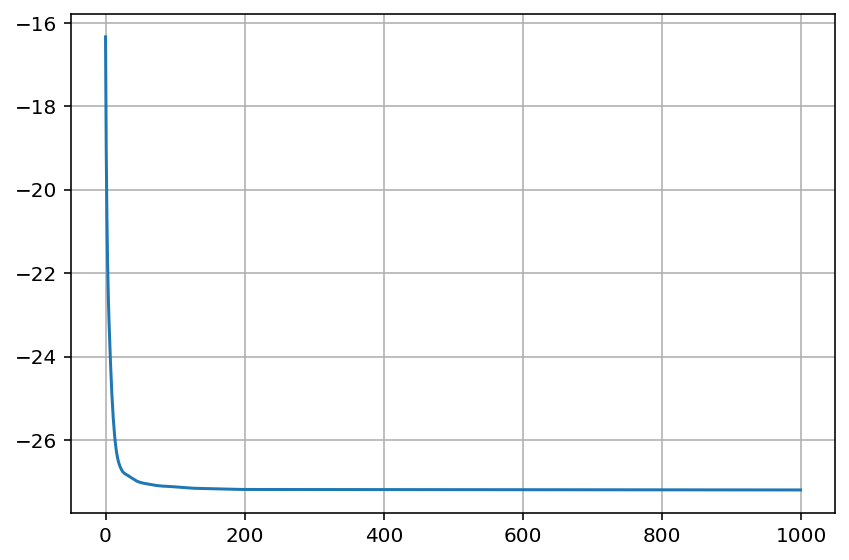

In [164]:
plt.figure()
plt.plot(loss)
plt.tight_layout()
plt.grid()
plt.show()

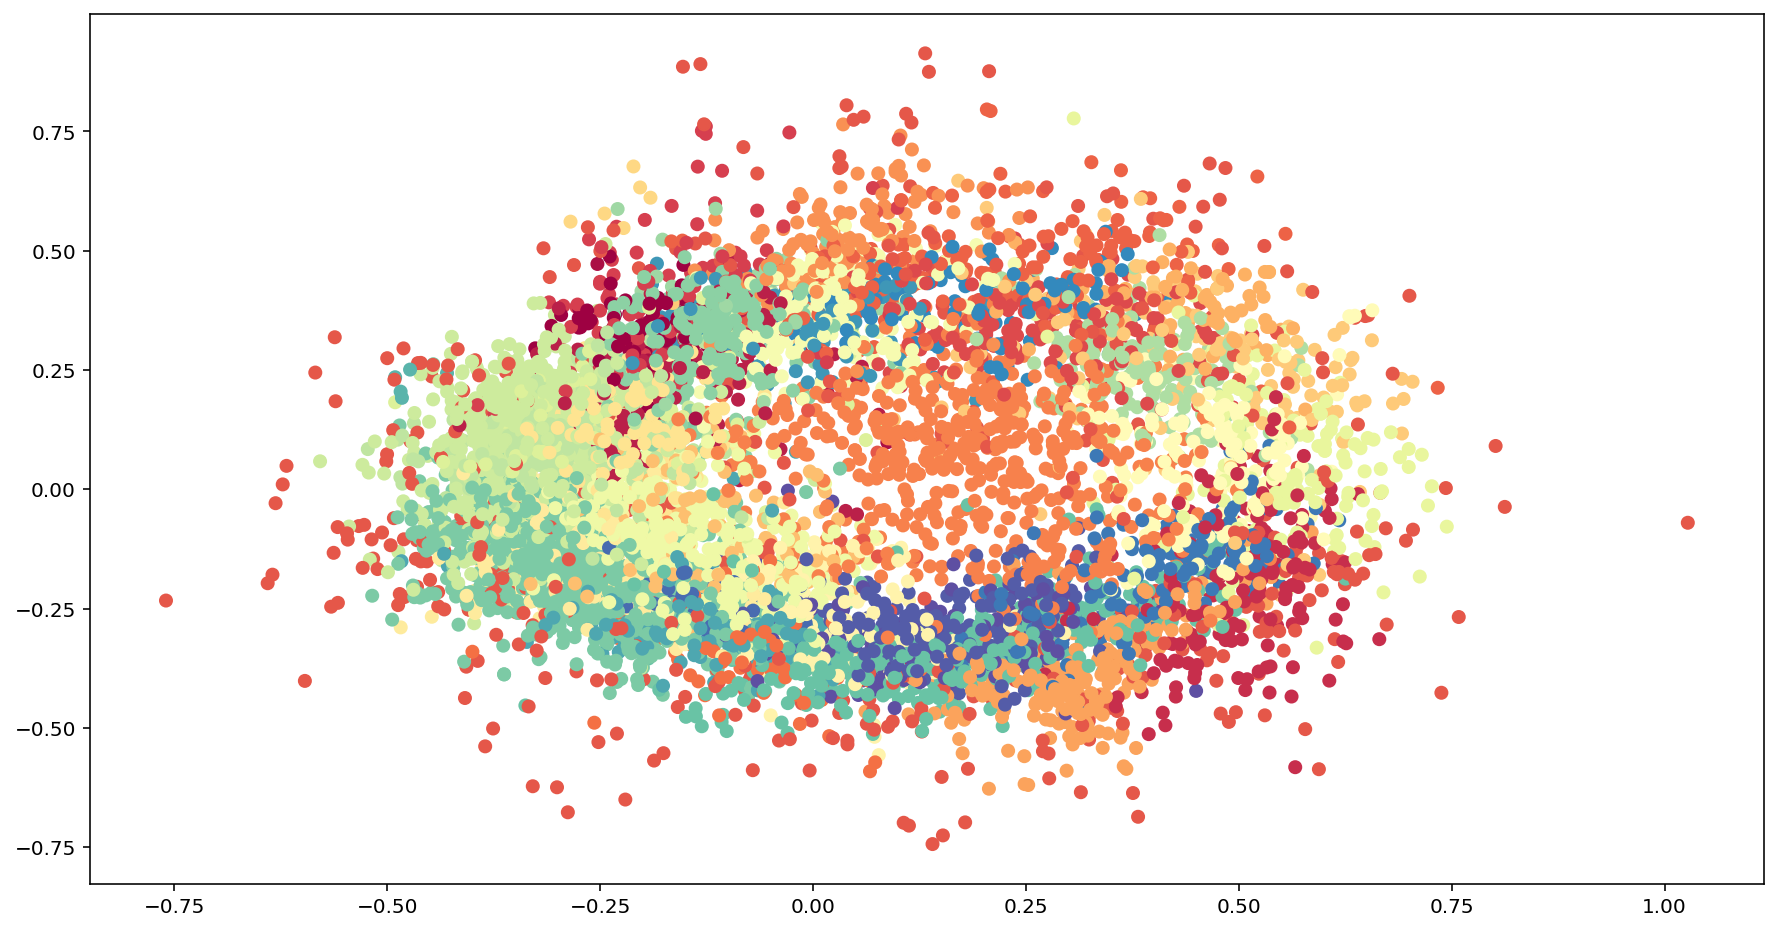

In [166]:
model.plot_clusters(data_[::10], dims=2)

In [167]:
model.plot_clusters(data_[::10], dims=3)

<Figure size 1080x576 with 0 Axes>